<a href="https://colab.research.google.com/github/2003UJAN/Heemangshu_Hackathon_Accident_Project/blob/main/CNN_for_Accident_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'accident-detection-from-cctv-footage:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F804753%2F1379553%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240421%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240421T185401Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D66858caad5dd54ac563d2a03fb52bbec360ef6835e73ca0ffe274314c0c55634045999f664b7eef5ba2f5fa52f9d70c9e2fafaa2467b18a00831c07fa7f5088930c35a65e398df11a2ebad8c015819d9ffef75716f64bf3d4e85342aa6c5dcee621f4303850828c0f53d0b931d503dc8fb030466669d5fa02121098fb54ee7e861ce8eb29d8b9f0ebc3c2f6b89d03daaaca3525ab88ff8c3f462c5a3d0e6dfd7c53d10209b43e8d4f6ca49686e0441fddf8466a164a08a31053cf7e6323d419624ccca027061aab4197e71d25783a86793f3b61553f0b341ab9741a044c2f0b3890e8a653b3174898d08a898b463ab7e9fa92be58264c7f2f055b5a0b1dedf9b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 261511923 bytes downloaded
Downloaded and uncompressed: accident-detection-from-cctv-footage
Data source import complete.


In [ ]:
##############################################################
# This notebook is for training a CNN for Accident detection #
# Framework is tensorflow                                    #
# This is MY usual solution that works in Most situations    #
# with reasonable Accuracy                                   #
# Thanks                                                     #
##############################################################

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter
import os


In [ ]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [ ]:
## loading training set
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 791 files belonging to 2 classes.


In [ ]:
## loading validation dataset
validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/val',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)


Found 98 files belonging to 2 classes.


In [ ]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)

class_names = training_ds.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)



Found 100 files belonging to 2 classes.


In [ ]:
## Defining Cnn
MyCnn = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
## lets train our CNN
retVal = MyCnn.fit(training_ds, validation_data= validation_ds, epochs = 10)

Epoch 1/10
8/8 [==============================] - 26s 1s/step - loss: 5.7774 - accuracy: 0.5348 - val_loss: 1.8401 - val_accuracy: 0.4694
Epoch 2/10
8/8 [==============================] - 2s 267ms/step - loss: 0.6776 - accuracy: 0.5651 - val_loss: 1.0793 - val_accuracy: 0.5306
Epoch 3/10
8/8 [==============================] - 3s 433ms/step - loss: 0.6404 - accuracy: 0.6220 - val_loss: 0.6455 - val_accuracy: 0.6122
Epoch 4/10
8/8 [==============================] - 2s 273ms/step - loss: 0.5735 - accuracy: 0.6991 - val_loss: 0.5349 - val_accuracy: 0.6633
Epoch 5/10
8/8 [==============================] - 2s 271ms/step - loss: 0.5233 - accuracy: 0.7370 - val_loss: 0.5947 - val_accuracy: 0.6122
Epoch 6/10
8/8 [==============================] - 2s 269ms/step - loss: 0.4524 - accuracy: 0.7990 - val_loss: 0.6216 - val_accuracy: 0.6939
Epoch 7/10
8/8 [==============================] - 2s 268ms/step - loss: 0.3381 - accuracy: 0.8673 - val_loss: 0.4507 - val_accuracy: 0.7347
Epoch 8/10
8/8 [======

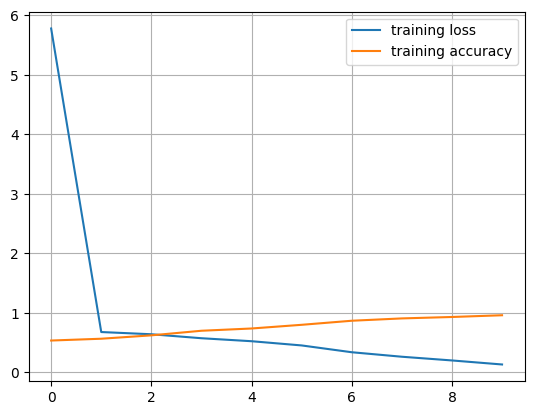

In [ ]:
## stats on training data
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

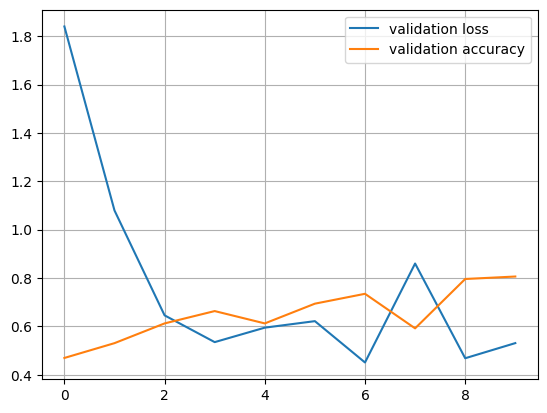

In [ ]:
## stats on validation data
plt.plot(retVal.history['val_loss'], label = 'validation loss')
plt.plot(retVal.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

4/4 [==============================] - 1s 82ms/step


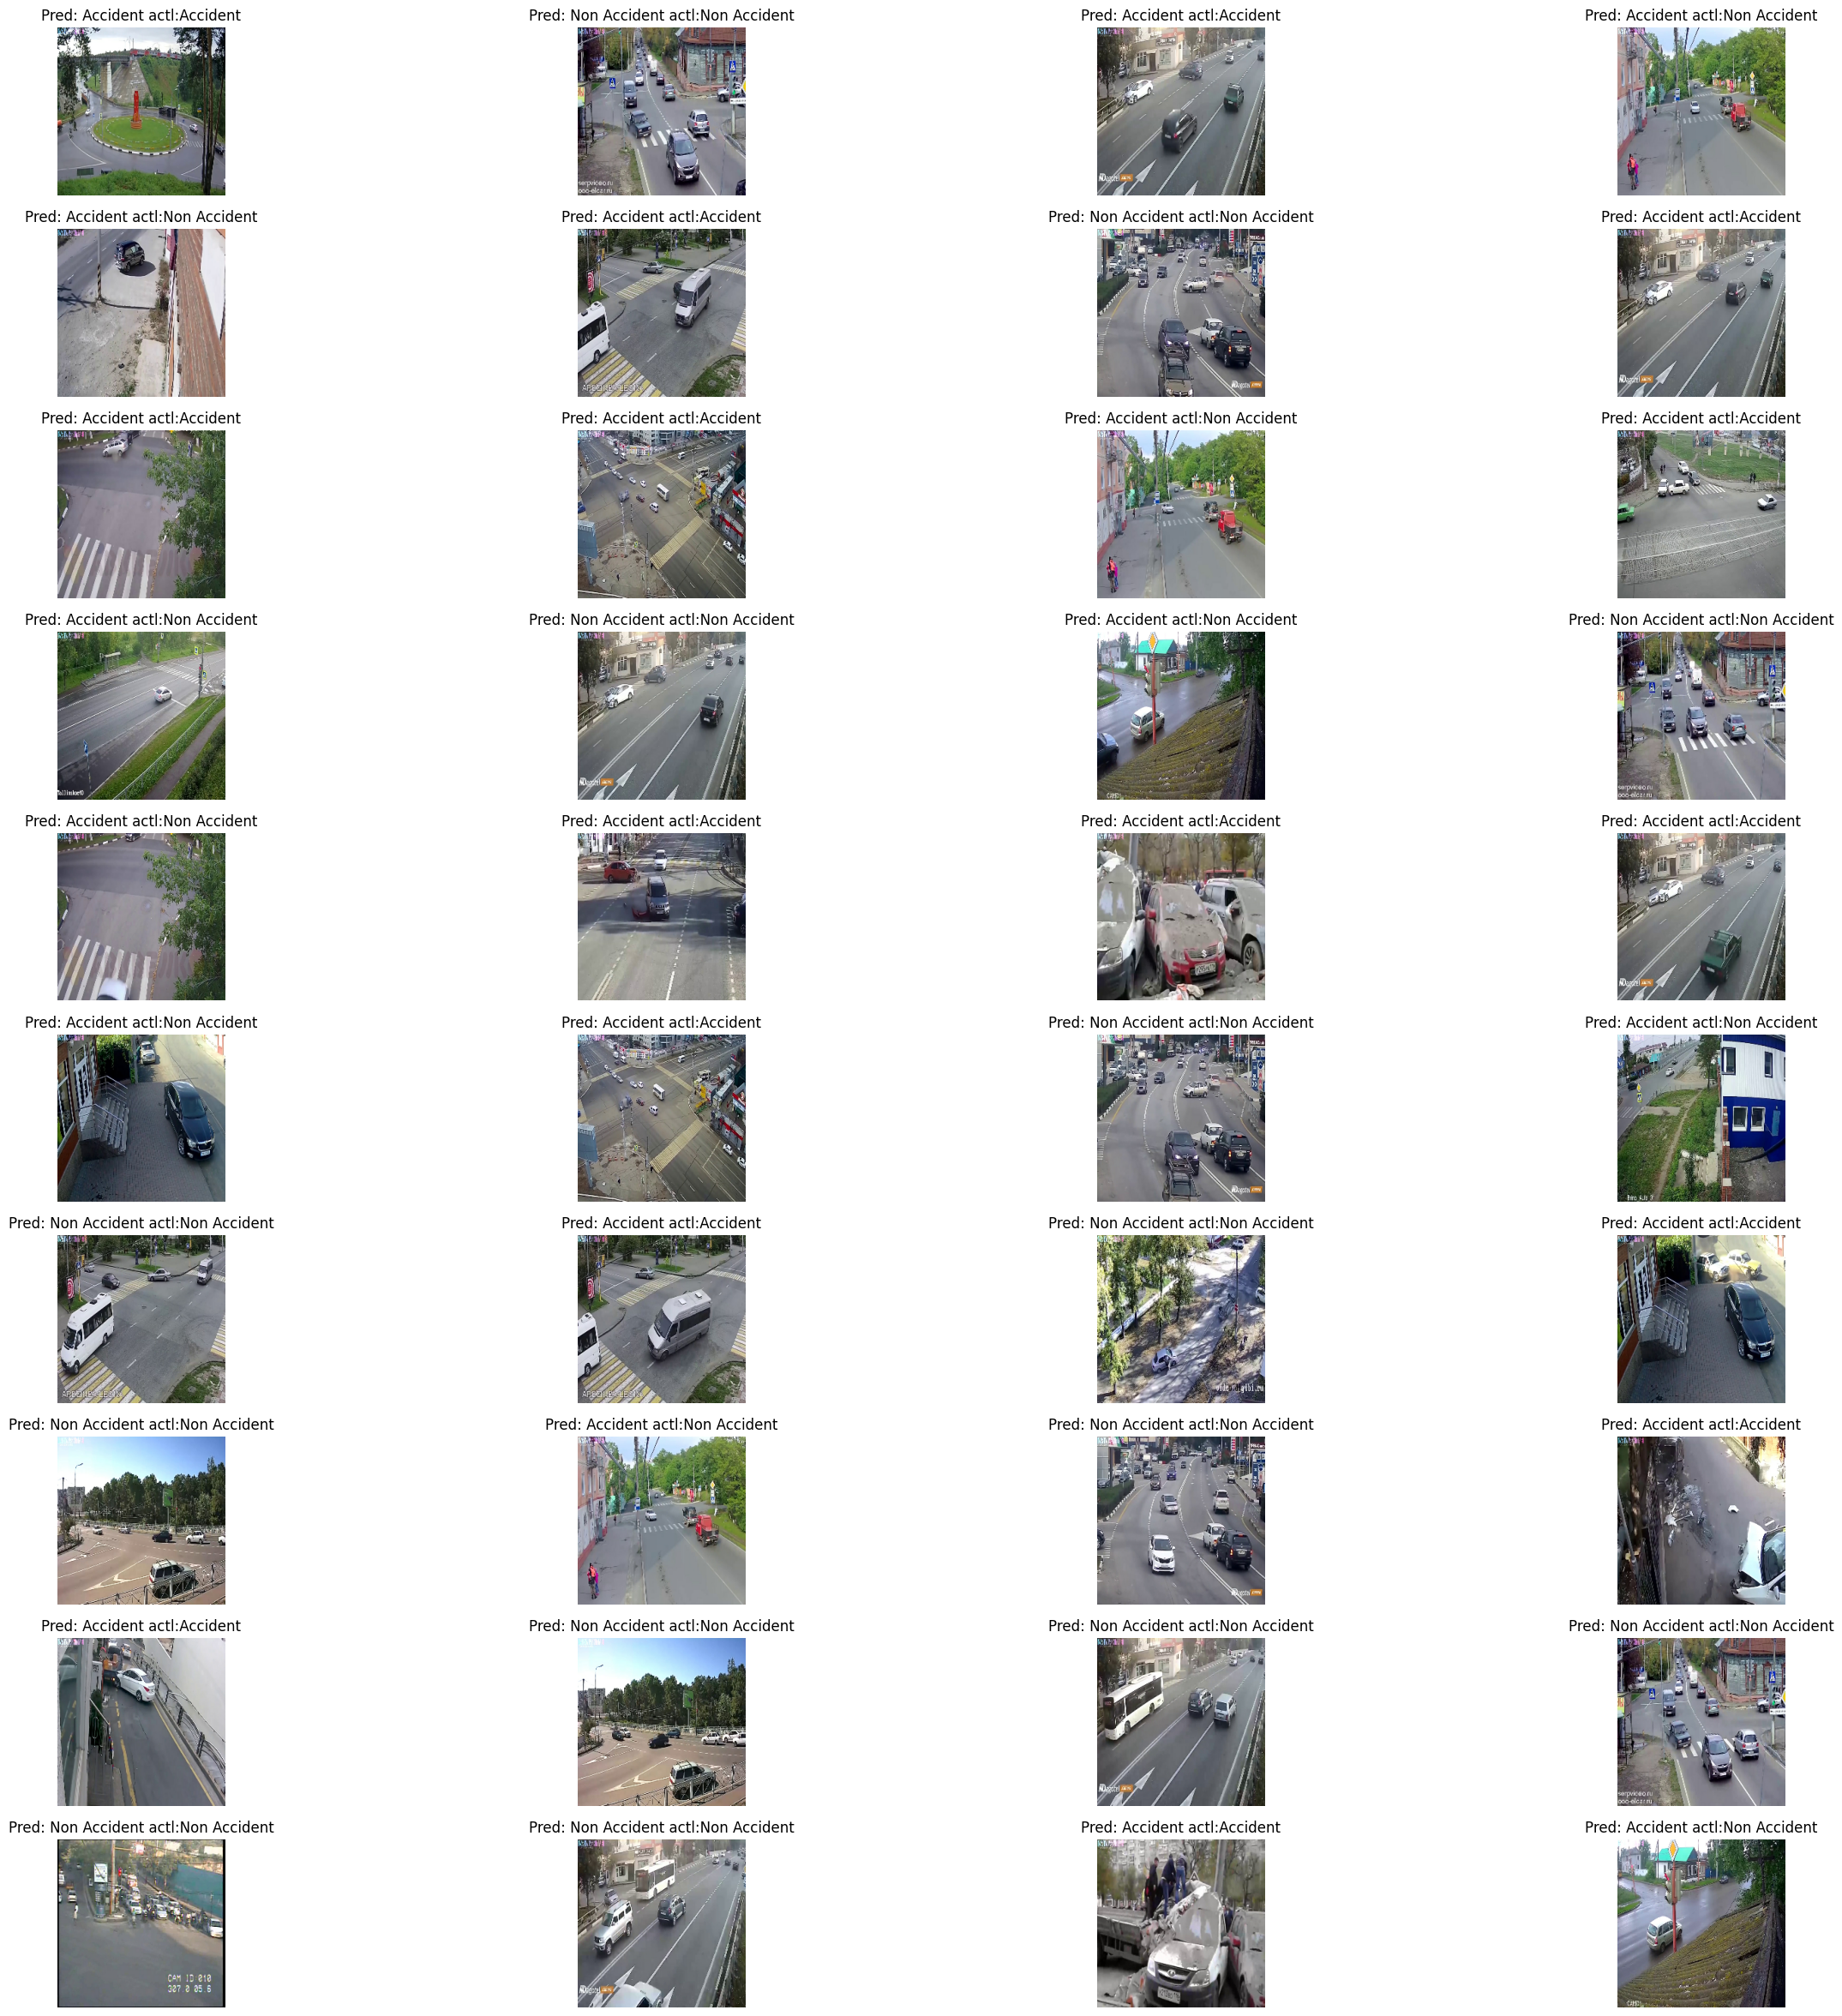

In [ ]:
## lets vizualize results on testing data
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_ds.take(1):
    predictions = MyCnn.predict(images)
    predlabel = []
    prdlbl = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))

    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [ ]:
MyCnn.save('Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


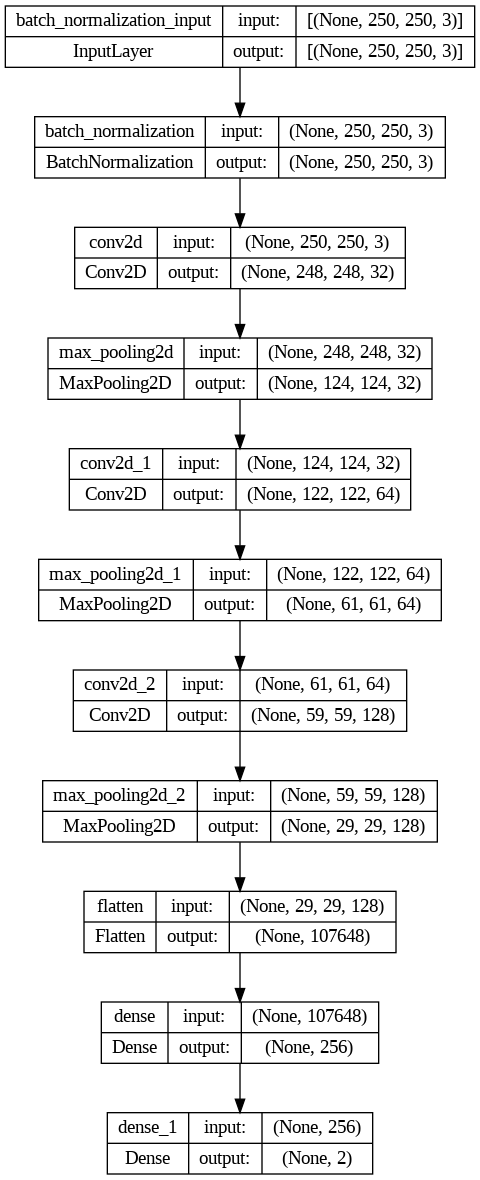

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(MyCnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
